In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings
warnings.filterwarnings('ignore')

In [32]:
mat_data = scipy.io.loadmat('MNIST.mat')
X = mat_data['X']
Y = mat_data['I'].T
print(X.shape)
print(Y.shape)

(256, 1707)
(1707, 1)


In [33]:
def backtracking(f, grad_f, x, Xhat):
    alpha = 1
    c = 0.8
    tau = 0.25
    while np.linalg.norm(f(x - alpha * grad_f(x, Xhat), Xhat)) > np.linalg.norm(f(x, Xhat)) - c * alpha * np.linalg.norm(grad_f(x, Xhat), 2) ** 2:
        alpha = tau * alpha
        if alpha < 1e-3:
            break
    return alpha

In [34]:
def GD(f, grad_f, x0, D, kmax, tolf, tolx):
    X, y = D
    N = X.shape[1]
    Xhat =  np.concatenate((np.ones((1,N)), X), axis=0)
    xsol=x0
    x=[x0]
    err=[np.linalg.norm(grad_f(xsol,Xhat))]
    i=0
    cond = True
    while i < kmax and cond :
        alpha = backtracking(f, grad_f, xsol, Xhat)
        xsol=(xsol-alpha*grad_f(xsol,Xhat))
        x.append(xsol)
        err.append(np.linalg.norm(grad_f(xsol, Xhat)))
        i+=1
        cond =  np.linalg.norm(grad_f(xsol, Xhat)) > tolf*np.linalg.norm(grad_f(x0, Xhat)) and np.linalg.norm(x[i]-x[i-1]) > tolx
    return x,i,err

In [35]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def grad_sigmoid(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

In [36]:
def f(w, X):
    return sigmoid(X.T @ w)  

def grad_f(w, X): # w (257,1)  X (257,210)
    #print(w.shape,X.shape)
    z = X.T @ w  # (210,1)
    #print(grad_sigmoid(z).shape)
    return X@grad_sigmoid(z) # (257,1)

In [37]:
def loss(f, w, D):
    X, y = D
    N = X.shape[1]
    MSE_s = 0
    for i in range(N):
        y_pred = f(w,X[:,i:i+1])
        MSE_s += np.square(y_pred -y[i,0])
    return MSE_s/N
    
def grad_loss(f, grad_f, w, D):
    X, y = D
    N = X.shape[1]
    gradient = 0
    for i in range(N):
        # Compute the prediction using the sigmoid function
        y_pred = f(w, X[:, i:i+1])
        # Compute the gradient of the loss with respect to the prediction
        dL_dy = 2 * (y_pred - y[i, 0])  # Gradient of Mean Squared Error (1,1)
        # Compute the gradient of the prediction with respect to the weights
        grad_f_w = grad_f(w, X[:, i:i+1]) #(257,1)
        # Update the gradient of the loss with respect to the weights
        gradient += grad_f_w @ dL_dy    #(257,1)
    return gradient/N #(257,1)

In [38]:
def SGD(loss, grad_loss, f, grad_f, w0, D, batch_size, n_epochs, learning_rate=1e-2):
    # Initialize w
    w = w0
    f_val = []
    w_vec = []
    grads = []
    err = []
    # Extract X and y
    X, y = D
    N = X.shape[1]
    Xhat =  np.concatenate((np.ones((1,N)), X), axis=0)
    # Compute the number of batches per epoch
    n_batch_per_epoch = N // batch_size
    # Iterate over the epochs
    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)
        # Batch iteration
        for k in range(n_batch_per_epoch):
            X_temp = Xhat[:,idx[k * batch_size : (k+1) * batch_size]]
            y_temp = y[idx[k * batch_size : (k+1) * batch_size],:]
            # Gradient descent update 
            w =  w - learning_rate * grad_loss(f, grad_f, w, (X_temp,y_temp))
        w_vec.append(w)
        f_val.append(loss(f, w, (Xhat, y)))
        grads.append(grad_loss(f, grad_f, w, (Xhat, y)))
        err.append(np.linalg.norm(grads[-1]))
    return w_vec, f_val, grads, err 

In [39]:
C1 = 6 #int(input("First digit:"))
C2 = 8 #int(input("Second digit:"))
idx = (Y[:,0] == C1) | (Y[:,0] == C2)
Ys = Y[idx,:]
for i in range(Ys.shape[0]):
    Ys[i,:] = 0 if Ys[i,:] == C1 else 1
Xs = X[:,idx]

In [40]:
def train_test_split(X, Y, N_train):
    d,N = X.shape
    idx = np.arange(0, N)
    np.random.shuffle(idx)
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    X_train = X[:,train_idx]
    Y_train = Y[train_idx,:]
    X_test = X[:,test_idx]
    Y_test = Y[test_idx,:]
    return X_train,Y_train,X_test,Y_test
    
X_train,Y_train,X_test,Y_test = train_test_split(Xs, Ys, int(Xs.shape[1]/1.4))
N = X_train.shape[1]
print("Train=",N)
print("Test=",X_test.shape[1])

Train= 210
Test= 85


### With SGD

In [41]:
w0 = np.random.random((257,1))*0.01
w_v, f_v, grads_v, err_v = SGD(loss, grad_loss, f, grad_f, w0, (X_train,Y_train), 10, 50)

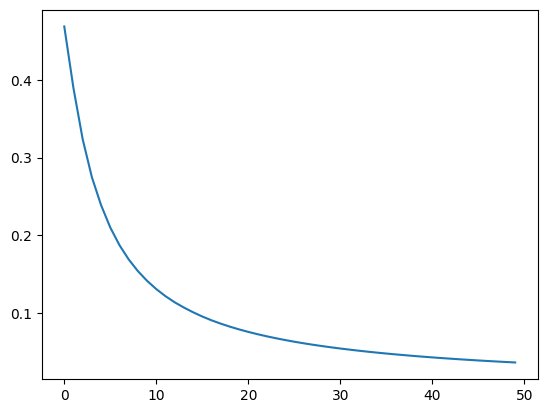

In [42]:
def predict(w, X, Y, treshold=0.5):
    N = X.shape[1]
    a = []
    cnt = 0
    x = np.concatenate((np.ones((1,N)), X), axis=0)
    for i in range(N):
        a.append(1 if f(w,x[:,i]) > treshold else 0)
        if a[-1] == Y[i,0]:
            cnt += 1
    return a,cnt
plt.plot(err_v)
plt.show()

for i in range(X_test.shape[1]):
    print(predict(x_comp[-1], X_test[:,i]),Y_test[i,0])


In [43]:
a, tot_train = predict(w_v[-1],X_train,Y_train)
N_train = X_train.shape[1]
print("Matches on train Set:", tot_train)
print("Total entries on train Set:", N_train)
print("Accuracy on train Set:", round(tot_train/N_train*100, 2))
a, tot_test = predict(w_v[-1],X_test,Y_test)
N_test = X_test.shape[1]
print("Matches on test Set:", tot_test)
print("Total entries on test Set:", N_test)
print("Accuracy on test Set:", round(tot_test/N_test*100, 2))

Matches on train Set: 209
Total entries on train Set: 210
Accuracy on train Set: 99.52
Matches on test Set: 84
Total entries on test Set: 85
Accuracy on test Set: 98.82


### With GD

In [44]:
x_comp, i_comp, err_comp = GD(f,grad_f,w0,(X_train,Y_train),10000, 1e-5, 1e-5)
#print("x=",x_comp[-1])
print("K=",i_comp)
print("Error=",err_comp[-1])

K= 10000
Error= 0.02618868417833393


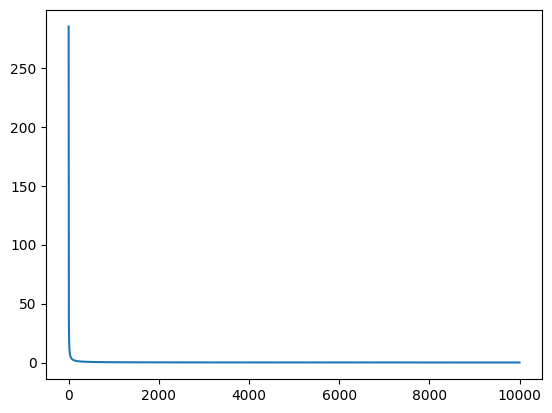

In [45]:
plt.plot(err_comp)
plt.show()

In [46]:
a, tot_train = predict(x_comp[-1],X_train,Y_train)
N_train = X_train.shape[1]
print("Matches on train Set:", tot_train)
print("Total entries on train Set:", N_train)
print("Accuracy on train Set:", round(tot_train/N_train*100, 2))
a, tot_test = predict(x_comp[-1],X_test,Y_test)
N_test = X_test.shape[1]
print("Matches on test Set:", tot_test)
print("Total entries on test Set:", N_test)
print("Accuracy on test Set:", round(tot_test/N_test*100, 2))

Matches on train Set: 105
Total entries on train Set: 210
Accuracy on train Set: 50.0
Matches on test Set: 46
Total entries on test Set: 85
Accuracy on test Set: 54.12
